In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
data = pd.read_csv('AirPassengers.csv')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
data.dtypes

Month          object
#Passengers     int64
dtype: object

In [4]:
data['Month'].value_counts()

1957-12    1
1957-09    1
1957-06    1
1958-10    1
1957-07    1
          ..
1958-12    1
1957-03    1
1955-01    1
1959-06    1
1951-05    1
Name: Month, Length: 144, dtype: int64

In [5]:
data.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [6]:
data.shape

(144, 2)

CREATING TIME SERIES OBJECT

In [7]:
#conversion of Month into a Time series object and use the Month column as our index.
from datetime import datetime
con=data['Month']
data['Month']=pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)


In [8]:
#check datatype of index
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [9]:
#convert to time series:
ts = data['#Passengers']
ts.head(10)

Month
1949-01-01    112
1949-02-01    118
1949-03-01    132
1949-04-01    129
1949-05-01    121
1949-06-01    135
1949-07-01    148
1949-08-01    148
1949-09-01    136
1949-10-01    119
Name: #Passengers, dtype: int64

In [10]:
ts['1960']

Month
1960-01-01    417
1960-02-01    391
1960-03-01    419
1960-04-01    461
1960-05-01    472
1960-06-01    535
1960-07-01    622
1960-08-01    606
1960-09-01    508
1960-10-01    461
1960-11-01    390
1960-12-01    432
Name: #Passengers, dtype: int64

In [11]:
data.dtypes

#Passengers    int64
dtype: object

C:\Users\admin\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


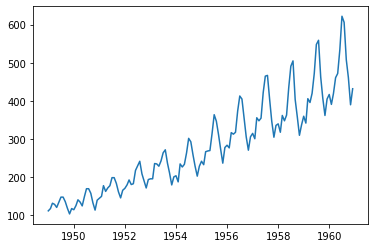

In [12]:
plt.plot(ts)

STATIONARITY TESTS

In [13]:
# check for stationarity using Dickey Fuller Test and plotting Rolling statistics.
from statsmodels.tsa.stattools import adfuller

In [14]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()

    rolstd = pd.Series(timeseries).rolling(window=12).std()
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print( 'Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

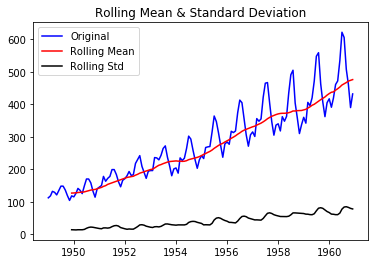

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [16]:
test_stationarity(ts)
#how to interpret the rolling statistics graph and dickey fuller results.

So test statistic 0.81 > all the critical values so we fail to reject the null hypothesis of dickey fulller test and say that the series is not stationary.
Now we will try to make it stationary.

Now , to make it stationary we have to remove trend and seasonality which can be done by differencing and decomposition.
seasonality can be seen using ACF plot.


DIFFERENCING AND TRANSFORMING (REDUCING TREND)

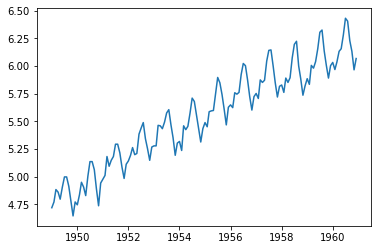

In [17]:
#reduce the trend using logarithmic transformation or differencing.
#(As there is a positive trend so we can use log,square root etc as transformation function)
ts_log = np.log(ts)
plt.plot(ts_log)

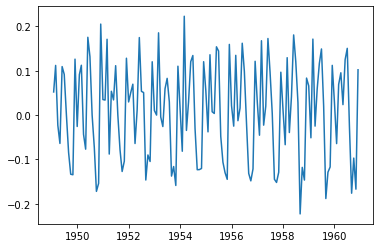

In [18]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

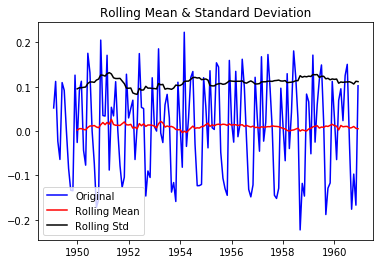

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [19]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

-2.71 < -2.57 so we reject the null hypothesis and can say with 90% confidence that series is stationary.
As we can see this does not make much difference to the original series. So now we model our trend and then remove it from series(a.k.a Detrend) There can be many ways of doing it like:

Aggregation – taking average for a time period like monthly/weekly averages
Smoothing – taking rolling averages
Polynomial Fitting – fit a regression model 

We will first decompose the series and see how the trend is if it will be a straight line then we will fit linear regression and then subtract the best fit line to detrend it. Otherwise if it behaves like an exponential curve then we do exponential smoothening.

DECOMPSITION

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

# Import Data
df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')



In [21]:
# Multiplicative Decomposition 
result_mul = seasonal_decompose(df['#Passengers'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
result_add = seasonal_decompose(df['#Passengers'], model='additive', extrapolate_trend='freq')



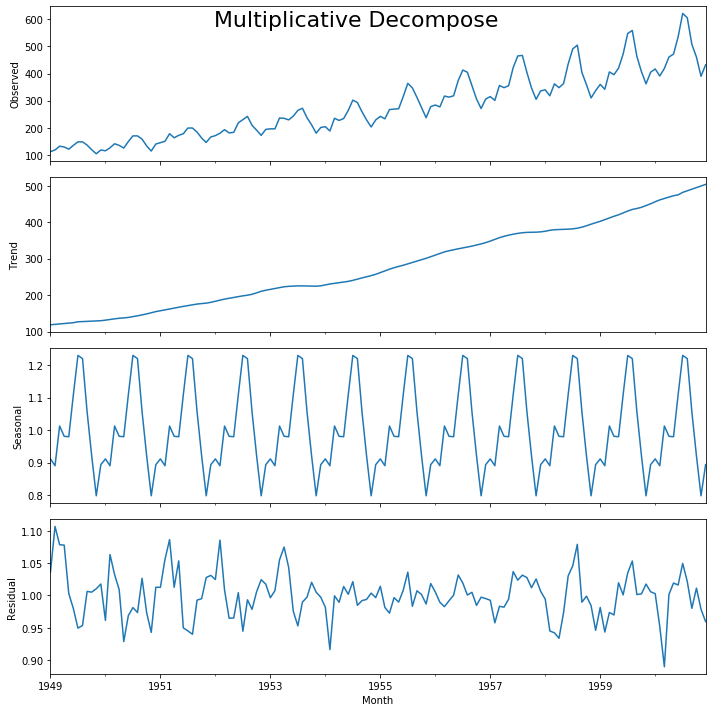

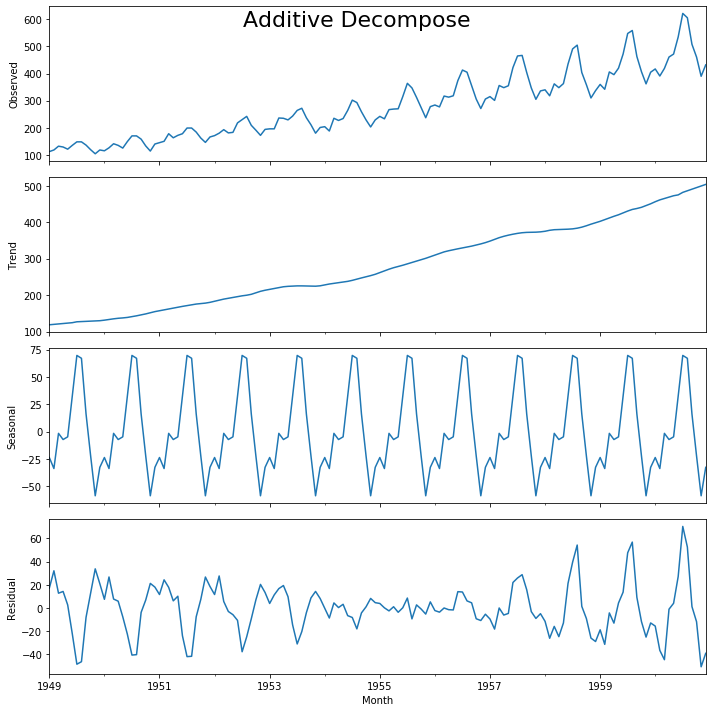

In [22]:
# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()


As we can see Trend is linear so to detrend it we will fit the regression model and will subtract the best fit line.
Athough we will do smoothining with moving average and exponential smoothening.(we haven't used aggregation)

DETREND

Text(0.5, 1.0, 'detrended by subtracting the least squares fit')

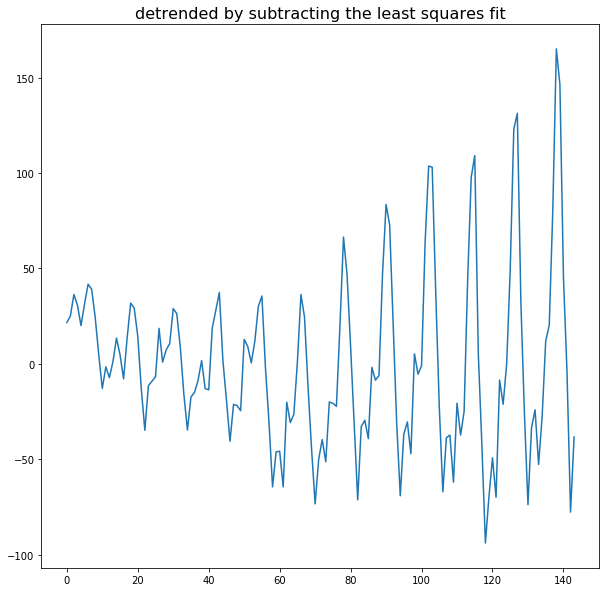

In [23]:
# Using scipy: Subtract the line of best fit
from scipy import signal
df = pd.read_csv('AirPassengers.csv', parse_dates=['Month'])
df['passengers'] = df['#Passengers'].tolist()
detrended = signal.detrend(df.passengers.values)
plt.plot(detrended)
plt.title('detrended by subtracting the least squares fit', fontsize=16)

Text(0.5, 1.0, 'detrended by subtracting the trend component')

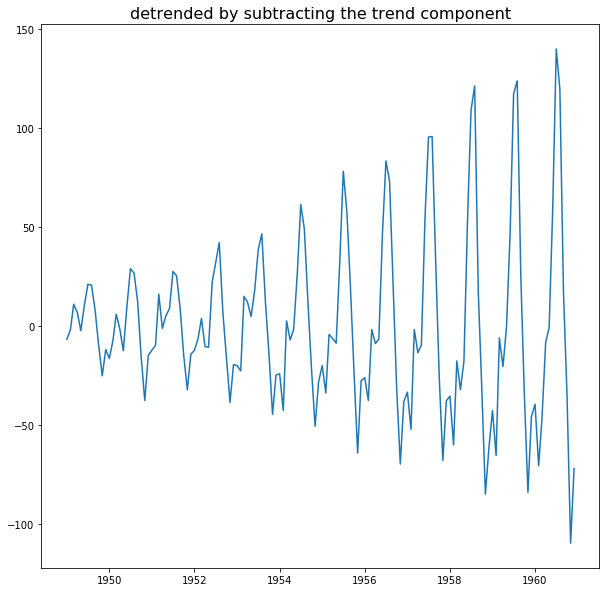

In [24]:
# Using statmodels: Subtracting the Trend Component.
from statsmodels.tsa.seasonal import seasonal_decompose
df1 = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month')
df1['passengers'] = df1['#Passengers'].tolist()
result_mul = seasonal_decompose(df1['#Passengers'], model='multiplicative', extrapolate_trend='freq')
detrended = df1.passengers.values - result_mul.trend
plt.plot(detrended)
plt.title('detrended by subtracting the trend component', fontsize=16)

DETREND2: SMOOTHENING USING MOVING AVERAGE 

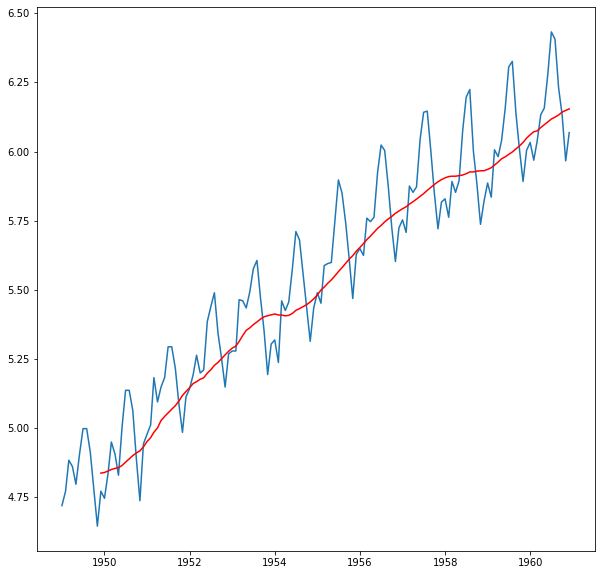

In [25]:
#First take x consecutive values and this depends on the frequency if it is 1 year we take 12 values. 
moving_avg = moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

The red line shows the rolling mean. Lets subtract this from the original series. Note that since we are taking average of last 12 values, rolling mean is not defined for first 11 values. 

In [26]:
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

Month
1949-01-01         NaN
1949-02-01         NaN
1949-03-01         NaN
1949-04-01         NaN
1949-05-01         NaN
1949-06-01         NaN
1949-07-01         NaN
1949-08-01         NaN
1949-09-01         NaN
1949-10-01         NaN
1949-11-01         NaN
1949-12-01   -0.065494
Name: #Passengers, dtype: float64

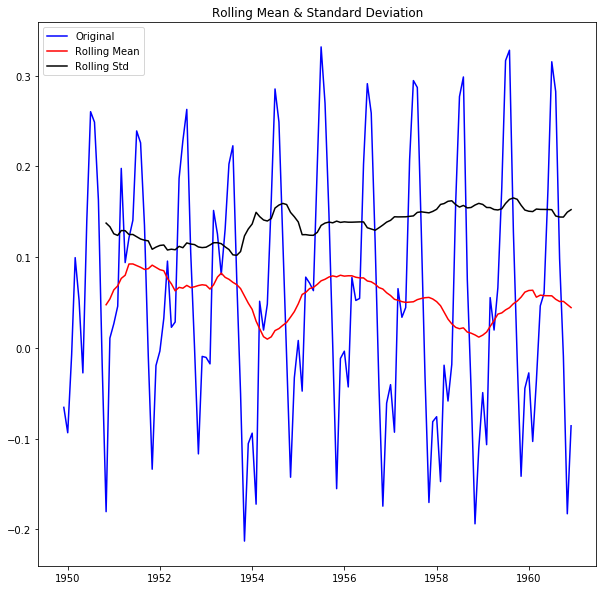

Results of Dickey-Fuller Test:
Test Statistic                  -3.162908
p-value                          0.022235
#Lags Used                      13.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [27]:
# drop these NaN values and check the plots to test stationarity.
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

so,test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

DETREND3 : SMOOTHNING USING EXPONENTIAL WEIGHTED AVERAGE

In [115]:
#expwighted_avg = ts_log.ewm(halflife = 12)

#plt.plot(ts_log)
#plt.plot(expwighted_avg, color='red')

CHECK FOR SEASONALITY (ACF PLOT)

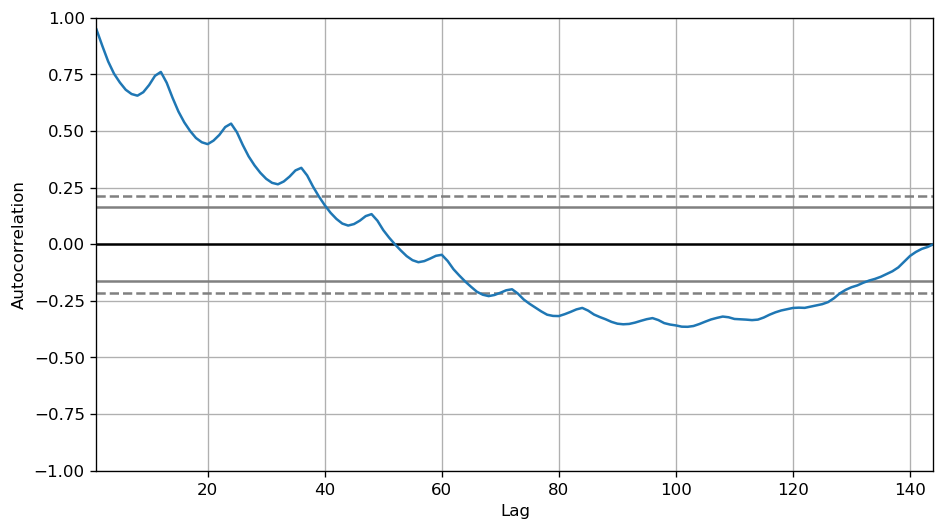

In [28]:
from pandas.plotting import autocorrelation_plot
df2 = pd.read_csv('AirPassengers.csv')
df2['passengers'] = df2['#Passengers'].tolist()

# Draw Plot
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
autocorrelation_plot(df2.passengers.tolist())

DESEASONALIZE

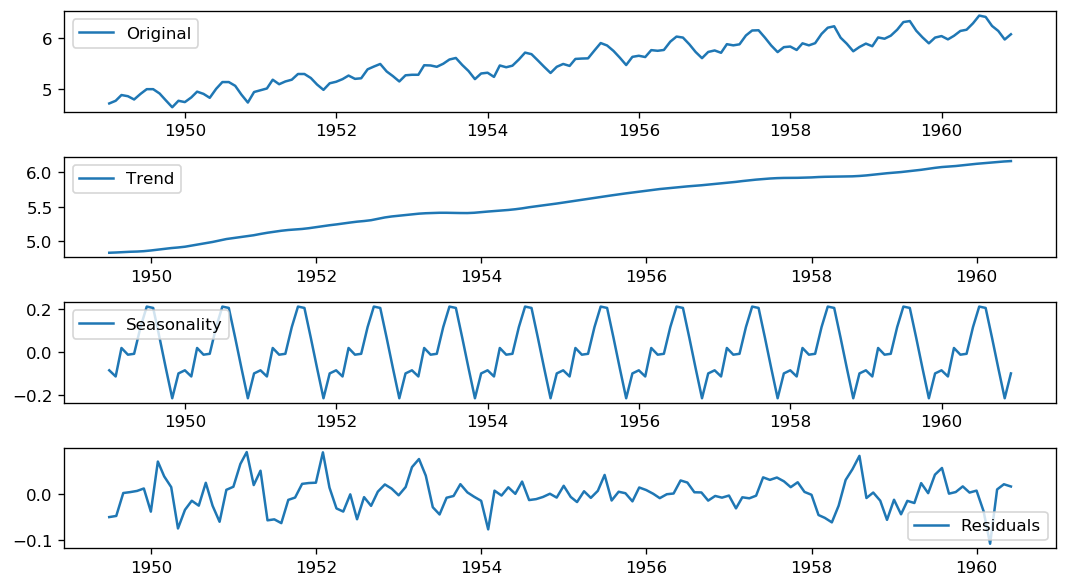

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

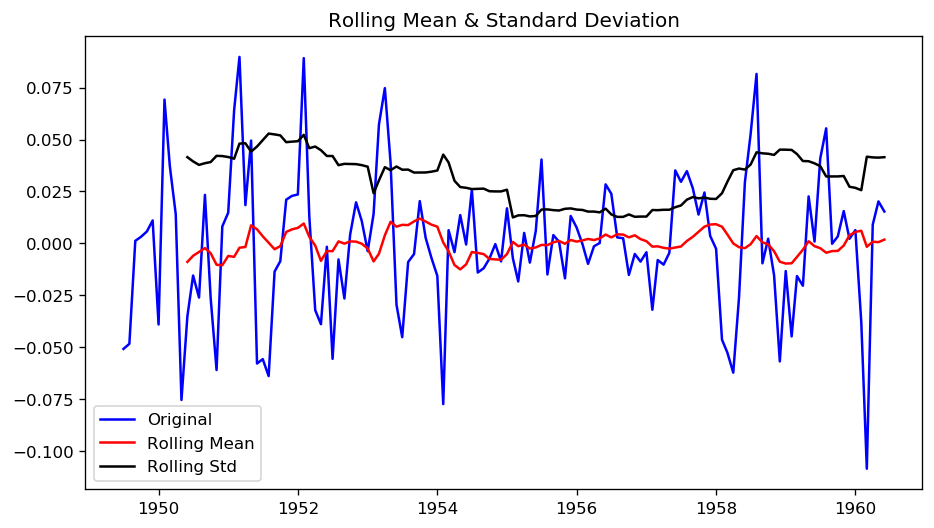

Results of Dickey-Fuller Test:
Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
Critical Value (10%)          -2.579569e+00
dtype: float64


In [30]:
#model the residuals
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

Now Test statistic < critical values so we reject the null hypothesis and will say that series is stationary.

ARIMA BY FINDING p,d,q

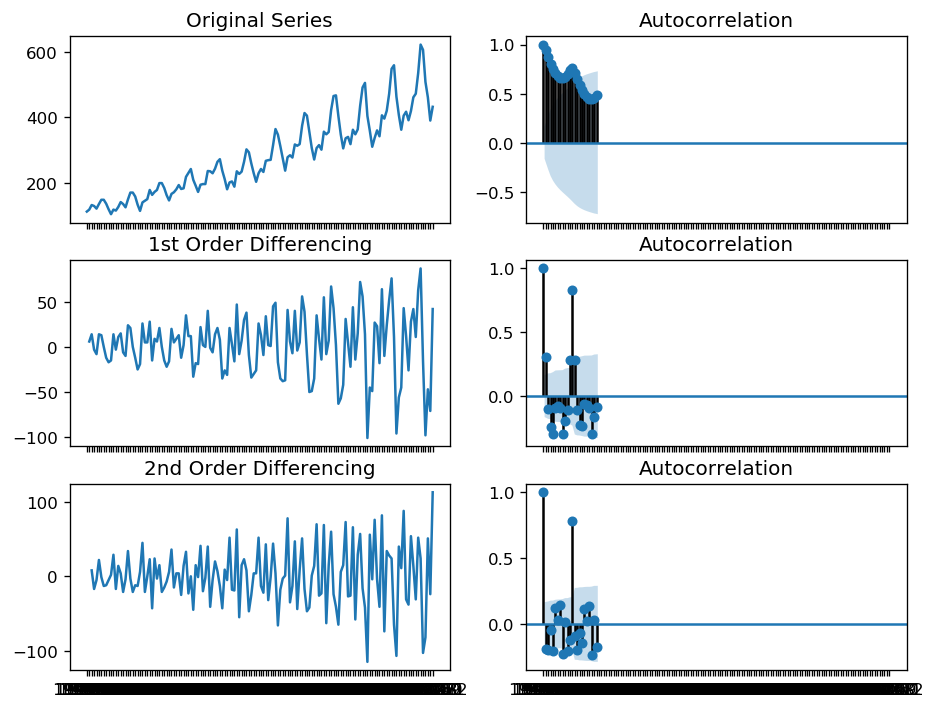

In [31]:
#Finding d
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Import data
df = pd.read_csv('AirPassengers.csv', names=['Month'], header=0)

# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df.Month); axes[0, 0].set_title('Original Series')
plot_acf(df.Month, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df.Month.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.Month.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df.Month.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.Month.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

In [32]:
#ACF and PACF plots to find p and q:
from statsmodels.tsa.stattools import acf, pacf

In [33]:
lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


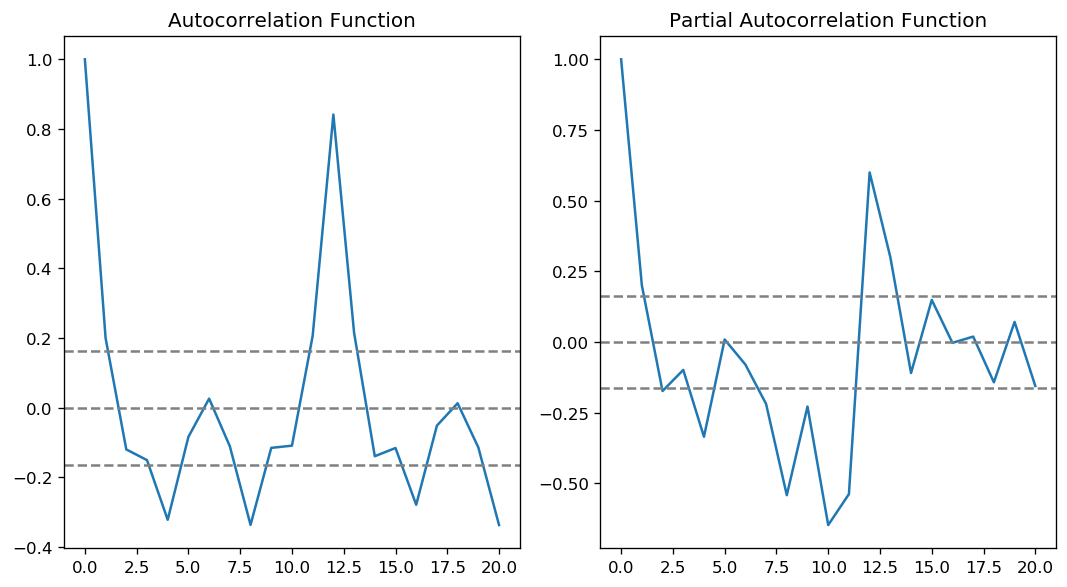

In [124]:
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [39]:
from statsmodels.tsa.arima_model import ARIMA

AR MODEL

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.5023')

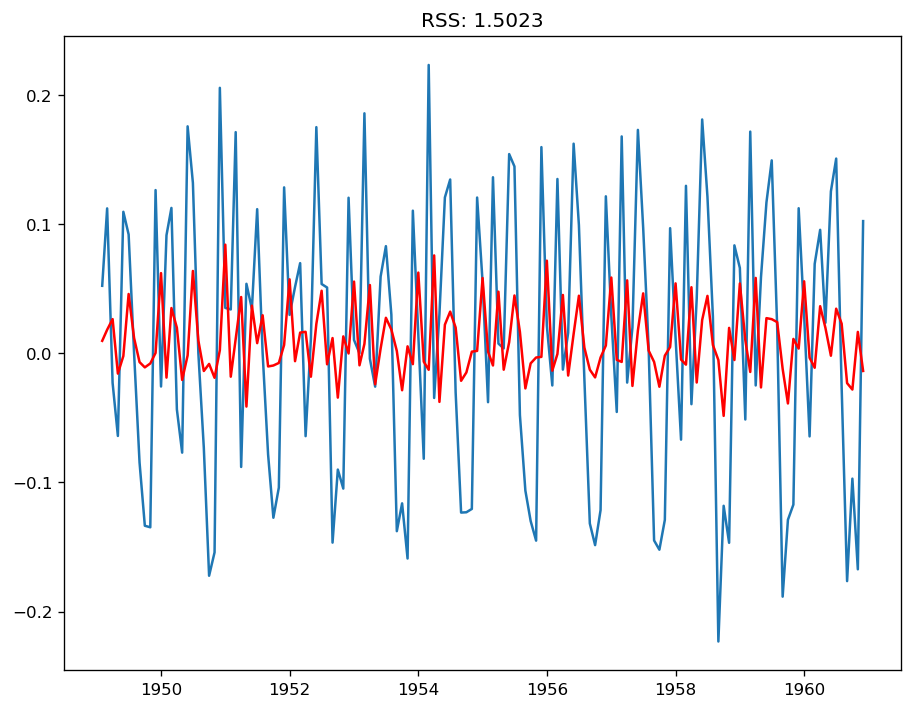

In [40]:
model = ARIMA(ts_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

MA MODEL

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Text(0.5, 1.0, 'RSS: 1.4721')

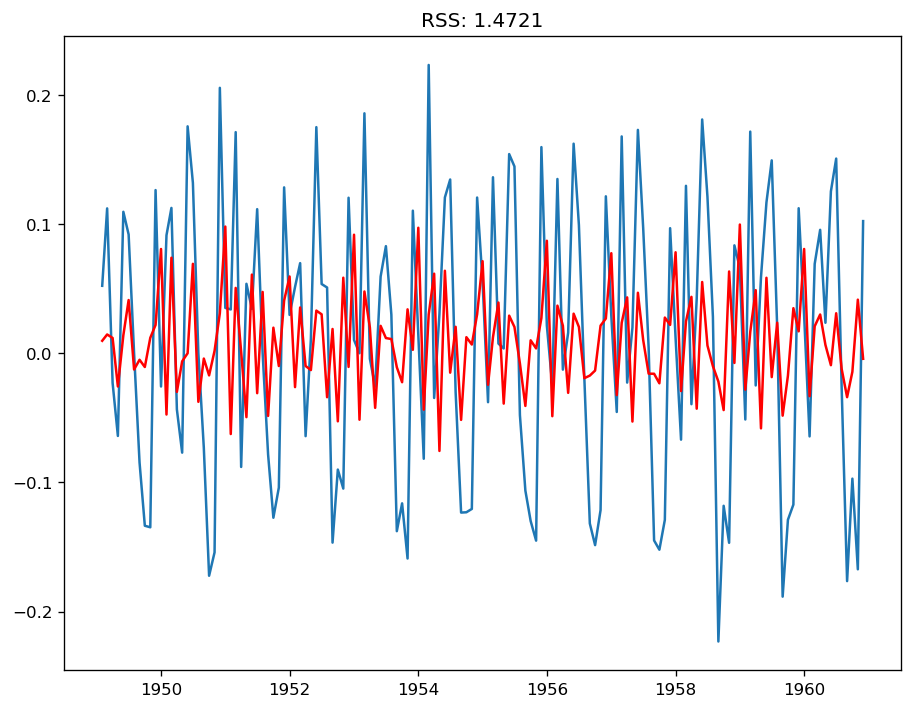

In [41]:
model = ARIMA(ts_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

ARIMA MODEL

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:         D2.#Passengers   No. Observations:                  142
Model:                 ARIMA(2, 2, 2)   Log Likelihood                 121.227
Method:                       css-mle   S.D. of innovations              0.101
Date:                Wed, 27 Nov 2019   AIC                           -230.454
Time:                        12:00:52   BIC                           -212.720
Sample:                    03-01-1949   HQIC                          -223.248
                         - 12-01-1960                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                -7.754e-05      0.000     -0.314      0.754      -0.001       0.000
ar.L1.D2.#Passengers    -0.5792      0.122     -4.736      0.000      -0.819      -0.339
ar.L2.D2.#Pa

Text(0.5, 1.0, 'RSS: nan')

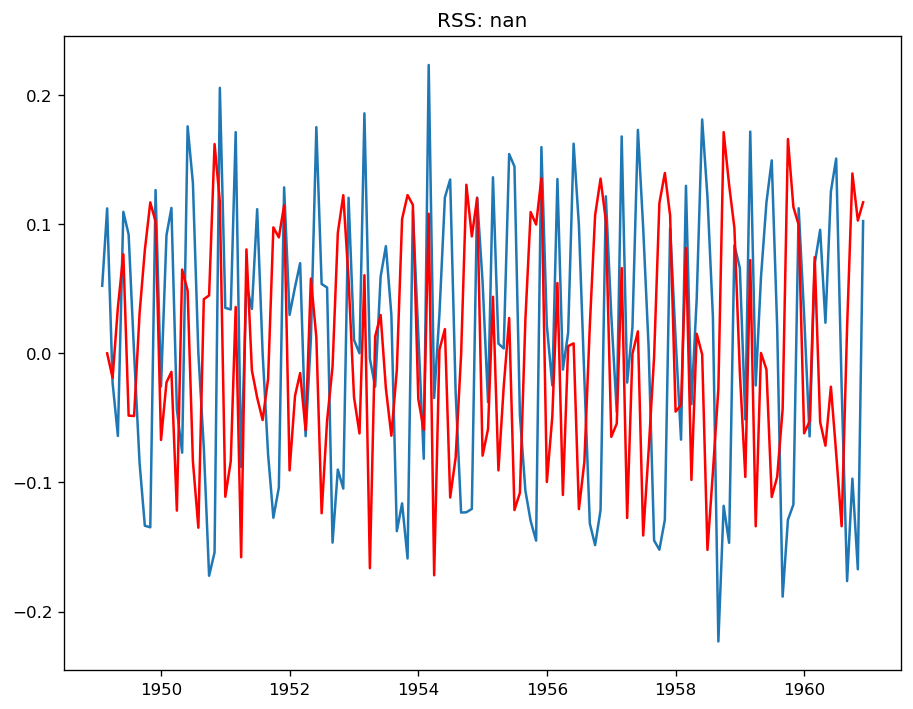

In [46]:
model = ARIMA(ts_log, order=(2, 2, 2))  
results_ARIMA = model.fit(disp=-1)
print(results_ARIMA.summary())
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [132]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.Month, order=(2,1,2))
model_fit = model.fit(disp=0)
print(model_fit.summary())

C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\admin\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Month   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -666.022
Method:                       css-mle   S.D. of innovations             24.712
Date:                Wed, 27 Nov 2019   AIC                           1344.043
Time:                        01:50:06   BIC                           1361.820
Sample:                    02-01-1949   HQIC                          1351.267
                         - 12-01-1960                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.5311      0.708      3.574      0.000       1.143       3.919
ar.L1.D.Month     1.6477      0.033     49.933      0.000       1.583       1.712
ar.L2.D.Month    -0.9094      0.033    -

In [47]:
# Plot residual errors to ensure there are no patterns
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

NameError: name 'model_fit' is not defined

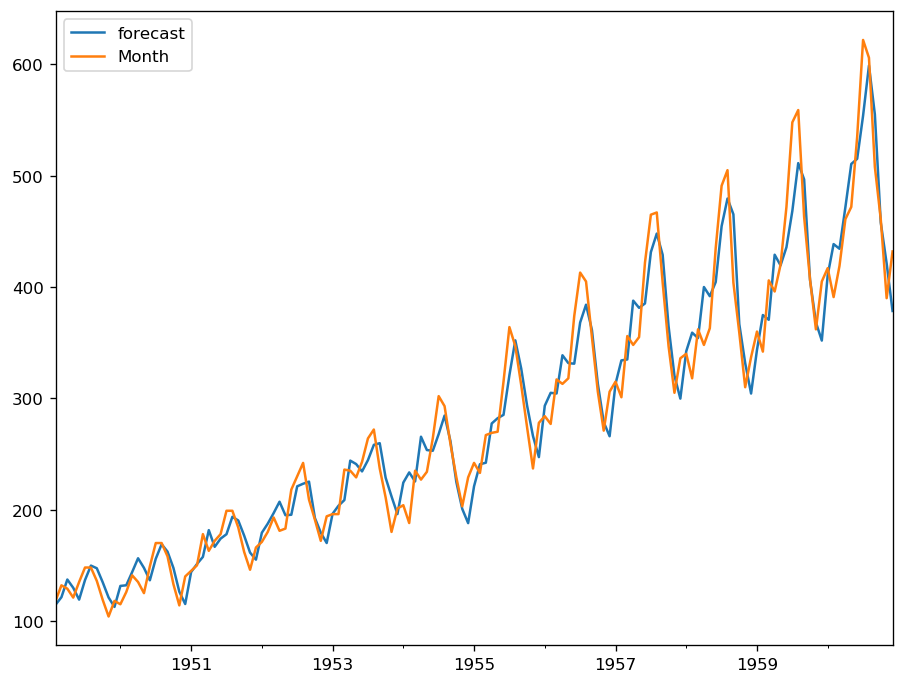

In [135]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()